# DATA 512 Final Project: Analysis of Wildfires in Gillette, Wyoming and Possible Impact on Education

##### In this project, we will be analyzing wildfire impacts on the city of Gillette in Wyoming. Part of this file uses code developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023

## Step 1: Extracting and Preparing Wildfire Data

##### The dataset used is the complete [Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons) dataset](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81). This dataset was collected and aggregated by the US Geological Survey.  

#### Step 1.1: Importing required libraries

In [2]:
#    Import some standard python modules
import json
import time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
import geojson
from tqdm import tqdm
import pandas as pd
import requests
import datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

#### Step 1.2: Defining constants

In [3]:
#
#    CONSTANTS
#

FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"


CITY_LOCATION = {
    'gillette': {'city': 'Gillette',
                 'latlon': [44.2911, -105.5022] }
}


#### Step 1.3: Loading the json wildfire dataset using geoJSON

In [4]:
#
#    Open a file, load it with the geojson loader
#
print(f"Attempting to open '{FILENAME}'")
with open(FILENAME,"r") as f:
    gj_data = geojson.load(f)


Attempting to open 'USGS_Wildland_Fire_Combined_Dataset.json'


FileNotFoundError: [Errno 2] No such file or directory: 'USGS_Wildland_Fire_Combined_Dataset.json'

In [4]:
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()

The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']



#### Step 1.4. Convert points between geodetic coordinate systems

##### There are many geocoordinate systems - descriptions of many of them at [EPSG.io](https://epsg.io). The geometry of the wildfire data are generic polygons that are expressed in a coordinate system with the well-known ID (WKID) 102008. This coordinate system is also known as [ESRI:102008](https://epsg.io/102008)

##### 'WGS84' is a representation of the earth, that also relies on a well known coordinate system that is sometimes called 'decimal degrees' (DD). That decimal degrees system has an official name (or WKID) of [EPSG:4326](https://epsg.io/4326).

##### The function below will take the geometry of a fire feature, extract the largest ring (i.e., the largest boundary of the fire) and convert all of the points in that ring from the ESRI:102008 coordinate system to EPSG:4326 coordinates.


In [3]:
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

#### Step 1.5. Compute distance between a place and a wildfire
##### The function below uses the Geod() object from PyProj to find the point on the perimeter of the with the shortest distance to the city (place) and returns the distance as well as the latitude and longitude of the perimeter point.

In [4]:
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


#### Step 1.6. Filter Wildfire Incidents that occurred between 1963-2023 within 1250 miles from Gillette.

##### The code below extracts and filters wildfire incident data from a GeoJSON dataset. It calculates the distance from Gillette to the perimeter of each wildfire that occurred between 1963-2023, and if the distance is within 1250 miles, it stores the attributes of the incident in a Pandas DataFrame df. This process is part of data preparation for further analysis of wildfire incidents and their proximity to the city.

In [7]:
#    Get a city from our CITY_LOCATIONS constant as our starting position
place = CITY_LOCATION["gillette"]
attributes_list = []

for feature in tqdm(gj_data['features']):
    try:
        wf_year = feature['attributes']['Fire_Year']
        if 1963 <= wf_year <= 2023:
            ring_data = feature['geometry']['rings'][0]
        
        #   Compute using the shortest distance to any point on the perimeter
            distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)

            if distance[0] <= 1250.00:
                feature_attributes = feature['attributes']
                feature_attributes['Distance'] = distance[0]
                attributes_list.append(feature_attributes)
    except Exception as e:
        print(f"An error occurred : {e}")


# Create a DataFrame from the list of feature dictionaries
df = pd.DataFrame(attributes_list)


 81%|████████  | 109608/135061 [2:00:38<21:14, 19.98it/s]  

An error occurred : 'rings'


 82%|████████▏ | 110228/135061 [2:01:11<20:41, 20.00it/s]

An error occurred : 'rings'


 82%|████████▏ | 110640/135061 [2:01:38<35:21, 11.51it/s]

An error occurred : 'rings'


 83%|████████▎ | 111433/135061 [2:02:21<16:37, 23.68it/s]

An error occurred : 'rings'


 83%|████████▎ | 111780/135061 [2:02:37<17:56, 21.62it/s]

An error occurred : 'rings'


 83%|████████▎ | 111902/135061 [2:02:43<17:16, 22.34it/s]

An error occurred : 'rings'


 83%|████████▎ | 112414/135061 [2:03:08<15:52, 23.78it/s]

An error occurred : 'rings'
An error occurred : 'rings'


 84%|████████▍ | 113413/135061 [2:03:55<15:25, 23.39it/s]

An error occurred : 'rings'


 84%|████████▍ | 113668/135061 [2:04:08<15:06, 23.61it/s]

An error occurred : 'rings'


 84%|████████▍ | 113740/135061 [2:04:11<15:09, 23.44it/s]

An error occurred : 'rings'


 84%|████████▍ | 113771/135061 [2:04:12<15:39, 22.65it/s]

An error occurred : 'rings'


 84%|████████▍ | 113806/135061 [2:04:14<17:11, 20.60it/s]

An error occurred : 'rings'


 85%|████████▍ | 114314/135061 [2:04:42<14:44, 23.45it/s]

An error occurred : 'rings'


 85%|████████▍ | 114326/135061 [2:04:42<14:58, 23.07it/s]

An error occurred : 'rings'


 86%|████████▌ | 115632/135061 [2:05:43<14:06, 22.96it/s]

An error occurred : 'rings'


 86%|████████▌ | 115977/135061 [2:06:00<13:51, 22.94it/s]

An error occurred : 'rings'


 86%|████████▌ | 116239/135061 [2:06:12<14:28, 21.68it/s]

An error occurred : 'rings'


 87%|████████▋ | 117091/135061 [2:06:53<12:37, 23.73it/s]

An error occurred : 'rings'


 89%|████████▊ | 119586/135061 [2:08:51<13:17, 19.42it/s]

An error occurred : 'rings'


 89%|████████▊ | 119618/135061 [2:08:53<12:16, 20.97it/s]

An error occurred : 'rings'


 89%|████████▊ | 119753/135061 [2:08:59<10:41, 23.85it/s]

An error occurred : 'rings'


 89%|████████▉ | 119987/135061 [2:09:11<11:38, 21.57it/s]

An error occurred : 'rings'


 89%|████████▉ | 120214/135061 [2:09:22<11:10, 22.14it/s]

An error occurred : 'rings'


 89%|████████▉ | 120434/135061 [2:09:34<10:12, 23.89it/s]

An error occurred : 'rings'


 89%|████████▉ | 120681/135061 [2:09:45<10:44, 22.31it/s]

An error occurred : 'rings'


 89%|████████▉ | 120748/135061 [2:09:49<10:41, 22.31it/s]

An error occurred : 'rings'


 90%|████████▉ | 121013/135061 [2:10:01<09:57, 23.52it/s]

An error occurred : 'rings'


 91%|█████████ | 122266/135061 [2:11:00<09:58, 21.37it/s]

An error occurred : 'rings'


 91%|█████████ | 122536/135061 [2:11:13<09:05, 22.94it/s]

An error occurred : 'rings'


 92%|█████████▏| 123764/135061 [2:12:10<08:07, 23.16it/s]

An error occurred : 'rings'


 92%|█████████▏| 124537/135061 [2:12:51<08:34, 20.46it/s]

An error occurred : 'rings'


 93%|█████████▎| 125050/135061 [2:13:16<07:12, 23.16it/s]

An error occurred : 'rings'


 93%|█████████▎| 125750/135061 [2:13:50<06:38, 23.34it/s]

An error occurred : 'rings'


 94%|█████████▍| 127496/135061 [2:15:13<05:33, 22.71it/s]

An error occurred : 'rings'


100%|██████████| 135061/135061 [2:21:04<00:00, 15.96it/s] 


##### From the result above, we can see that the attribute 'rings' was not present in all records in the wildfire dataset. The overall fireset produces 135,000+ rows. As the number of records that were not read is around 50, these are ignored. 

In [10]:
# df.to_csv('fire_data.csv', index=False)

##### Storing the results as an intermediate file 'fire_data.csv' so that the distances do not have to be calculated again. 

In [5]:
file = r"C:\Users\mehja\Documents\UW Masters\DATA 512 Human Centered Data Science\Project\fire_data_json.csv"
df = pd.read_csv(file)

C:\Users\mehja\AppData\Local\Temp\ipykernel_18664\2910247501.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [6]:
# Drop the variables that are not needed.
df_analysis = df.drop(columns=['OBJECTID', 'Assigned_Fire_Type',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area'])

## Step 2: Extracting and Preparing Air Quality Index Data

##### The code below requests data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data.   

#### Step 2.1: Defining Constants

In [7]:
#########
#
#    CONSTANTS
#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "56",     # the two digit state FIPS # as a string
    "county":     "005",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

#### Step 2.1. Making a sign-up request

##### Before we use the API we need request a key using an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests. YThe sign-up only needs to be done once. 


In [14]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

##### The sign-up is completed below and therefore has been commented out of the code. 

In [9]:
#print("Requesting SIGNUP ...")
#response = request_signup("mzameer@uw.edu")
#print(json.dumps(response,indent=4))

Requesting SIGNUP ...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2023-11-06T21:18:07-05:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=mzameer@uw.edu"
        }
    ],
    "Data": [
        "You should receive a registration confirmation email with a link for confirming your email shortly."
    ]
}


In [16]:
USERNAME = "mzameer@uw.edu"
APIKEY = "aquaram62"

#### Step 2.2 Making a list request
##### Once we have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. 

In [17]:
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [18]:
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

##### We want to extract Air Quality Index (AQI). The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...). From the list produced by our 'list/Classes' request above, there is a class of sensors called "AQI POLLUTANTS". The code below gets a list of those specific sensors. 

In [19]:
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

In [20]:
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


##### We now have a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

##### The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We break it up into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [21]:
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

##### Air quality monitoring stations are located all over the US at different locations. We extract the ones near Gillette, Wyoming using the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) code.

In [22]:
CITY_LOCATIONS = {
    'gillette' :       {'city'   : 'Gillette',
                       'county' : 'Campbell',
                       'state'  : 'Wyoming',
                       'fips'   : '56005',
                       'latlon' : [44.2911, -105.5022] }
}

##### We now find monitoring locations that are nearby by getting the EPA to list their monitoring stations near Campbell County where Gillette is located.

In [23]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['gillette']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['gillette']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": "Black Thunder BTM-7"
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": "Hilight-Reno Junction Gas Plant"
    },
    {
        "code": "0012",
        "value_represented": "Fortification Creek (WARMS site)"
    },
    {
        "code": "0013",
        "value_represented": "NARM NA-9"

##### The above response gives us a list of monitoring stations. Each monitoring station has a unique "code" which is a string number, and, sometimes, a description. The description seems to be something about where the monitoring station is located.


#### Step 2.3. Making a daily summary request

##### The function below is encapsulates requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

##### Another function below provides an example of extracting values and restructuring the response to make it a little more usable.

In [24]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



##### The function below takes the response and a set of fields that should be extracted for their data values.The function creates a summary for each monitoring site.

In [25]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


#### Step 2.4. Extracting AQI data from the summary

##### The code below defines a function that retrieves daily air quality summary data for gaseous and particulate pollutants for a specified range of years (from start_year to end_year). It uses a request template to fetch data for each year and stores the data in separate lists (yearly_gaseous_data and yearly_particulate_data). The function also checks the response status for each request, extracts and appends the summary data to the respective lists, and prints a message if no data is available or if there's an issue with the request. This allows the code to gather air quality data for multiple years, facilitating further analysis and processing of the data.

In [26]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['gillette']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['gillette']['fips'][2:]

In [27]:
# Define the start and end years
start_year = 1974 #checked and data for the county starts from 1974 so starting from there.
end_year = 2020 #fire data ends in 2020 so not extracting AQI beyond that. 

# Create an empty list to store the data for each year
yearly_gaseous_data = []
yearly_particulate_data = []

for year in range(start_year, end_year + 1):
    # Define the start and end dates for the current year
    start_date = datetime.date(year, 1, 1)
    enddate = datetime.date(year, 12, 31)

    # Convert the start and end dates to the required format (YYYYMMDD)
    start_date = start_date.strftime("%Y%m%d")
    enddate = enddate.strftime("%Y%m%d")

    request_data['param'] = AQI_PARAMS_GASEOUS
# request daily summary data for the month of July in 2021
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=enddate)
    print(f"Response for the gaseous pollutants for {start_date} ...")

    if gaseous_aqi["Header"][0]['status'] == "Success":
        extract_gaseous = extract_summary_from_response(gaseous_aqi)
        yearly_gaseous_data.append(extract_gaseous)
    elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
        print("No data generated")
    else:
        print(json.dumps(gaseous_aqi,indent=4))

    request_data['param'] = AQI_PARAMS_PARTICULATES

    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=enddate)
    print(f"Response for the particulate pollutants for {start_date} ...")

    if particulate_aqi["Header"][0]['status'] == "Success":
        extract_particulate = extract_summary_from_response(particulate_aqi)
        yearly_particulate_data.append(extract_particulate)
    elif particulate_aqi["Header"][0]['status'].startswith("No data "):
        print("No data generated")
    else:
        print(json.dumps(particulate_aqi,indent=4))


Response for the gaseous pollutants for 19740101 ...
Response for the particulate pollutants for 19740101 ...
No data generated
Response for the gaseous pollutants for 19750101 ...
Response for the particulate pollutants for 19750101 ...
No data generated
Response for the gaseous pollutants for 19760101 ...
Response for the particulate pollutants for 19760101 ...
No data generated
Response for the gaseous pollutants for 19770101 ...
Response for the particulate pollutants for 19770101 ...
No data generated
Response for the gaseous pollutants for 19780101 ...
Response for the particulate pollutants for 19780101 ...
No data generated
Response for the gaseous pollutants for 19790101 ...
Response for the particulate pollutants for 19790101 ...
No data generated
Response for the gaseous pollutants for 19800101 ...
Response for the particulate pollutants for 19800101 ...
No data generated
Response for the gaseous pollutants for 19810101 ...
Response for the particulate pollutants for 1981010

#### Step 2.5. Extracting Gaseous AQI data from the summary

##### The code below processes yearly air quality data for gaseous pollutants from multiple sites and observations. It starts by initializing a dictionary, yearly_gaseous_aqi, which will store the total AQI values and the number of entries for each year. The code iterates through the data, extracting information about pollutant types, years, and observations. For each observation, it calculates the total AQI values and the number of valid entries for that year, considering sample durations. The results are stored in the yearly_gaseous_aqi dictionary with keys representing years, and the corresponding tuples contain the total AQI and entry counts. This data can be further used for yearly air quality analysis and assessment.

In [30]:
# Initialize the yearly_gaseous_aqi dictionary as a defaultdict of lists of tuples
yearly_gaseous_aqi = defaultdict(list)

# Create a set to store unique sample_duration values
unique_sample_durations = set()

for entry in yearly_gaseous_data:
    # Iterate through the years and observations for each entry
    for site_id, site_data in entry.items():
        
        for pollutant_type, pollutant_data in site_data['pollutant_type'].items():
            
            # Extract the year from the date (e.g., '20200101' -> '2020')
            year = list(pollutant_data['data'].keys())[0][:4]
            # Initialize variables to calculate the yearly average
            total_aqi = 0
            num_entries = 0

            for date, date_data in pollutant_data['data'].items():
                for observation_data in date_data:

                    sample_duration = observation_data['sample_duration']
                    # Add it to the set
                    unique_sample_durations.add(sample_duration)
                
                    if observation_data['aqi'] is not None and observation_data['aqi'] != 0:
                        
                        total_aqi += observation_data['aqi']
                        num_entries += 1

            # Append the tuple (total_aqi, num_entries) to the year in yearly_aqi
            yearly_gaseous_aqi[year].append((total_aqi, num_entries))
          

#### Step 2.6. Extracting Particulate AQI data from the summary

##### We now repeat the step above for particulate AQI data. The code below processes yearly air quality data for particulate pollutants from multiple sites and observations. It starts by initializing a dictionary, yearly_particulate_aqi, which will store the total AQI values and the number of entries for each year. The code iterates through the data, extracting information about pollutant types, years, and observations. For each observation, it calculates the total AQI values and the number of valid entries for that year, considering sample durations. The results are stored in the yearly_particulate_aqi dictionary with keys representing years, and the corresponding tuples contain the total AQI and entry counts. This data can be further used for yearly air quality analysis and assessment.

In [31]:
# Initialize the yearly_particulate_aqi dictionary as a defaultdict of lists of tuples
yearly_particulate_aqi = defaultdict(list)

# Create a set to store unique sample_duration values
unique_sample_durations_particulate = set()

for entry in yearly_particulate_data:
    # Iterate through the years and observations for each entry
    for site_id, site_data in entry.items():
        
        for pollutant_type, pollutant_data in site_data['pollutant_type'].items():
            
            # Extract the year from the date (e.g., '20200101' -> '2020')
            year = list(pollutant_data['data'].keys())[0][:4]
            # Initialize variables to calculate the yearly average
            total_aqi = 0
            num_entries = 0

            for date, date_data in pollutant_data['data'].items():
                for observation_data in date_data:

                    sample_duration = observation_data['sample_duration']
                    # Add it to the set
                    unique_sample_durations_particulate.add(sample_duration)
                
                    if observation_data['aqi'] is not None and observation_data['aqi'] != 0:
                        total_aqi += observation_data['aqi']
                        num_entries += 1

            # Append the tuple (total_aqi, num_entries) to the year in yearly_aqi
            yearly_particulate_aqi[year].append((total_aqi, num_entries))
          

#### Step 2.7: Calculating AQI for each year. 

##### The code below calculates the annual average Air Quality Index (AQI) for each year using data from gaseous and particulate pollutants. It iterates through each year in yearly_gaseous_aqi, extracts the AQI values and the number of data points (entries) for both gaseous and particulate pollutants. Then, it combines the total AQI and data points from both types of pollutants. The annual average AQI is computed by dividing the total AQI by the total data points, ensuring a non-zero denominator to avoid division by zero. Finally, it updates the df_analysis DataFrame with the calculated average AQI for each corresponding year, rounding the values to two decimal places. This process allows for the aggregation of AQI data for further analysis and visualization.

In [32]:
for year in yearly_gaseous_aqi.keys():
    # Initialize variables for total AQI and data points
    total_aqi = 0
    total_data_points = 0

    # Extract AQI values and data points from gaseous AQI
    gaseous_aqi_entries = yearly_gaseous_aqi[year]
    gaseous_aqi_values = [value for value, _ in gaseous_aqi_entries]
    gaseous_data_points = [data_point for _, data_point in gaseous_aqi_entries]

    # Extract AQI values and data points from particulate AQI
    particulate_aqi_entries = yearly_particulate_aqi[year]
    particulate_aqi_values = [value for value, _ in particulate_aqi_entries]
    particulate_data_points = [data_point for _, data_point in particulate_aqi_entries]

    # Calculate the combined total AQI and data points
    total_aqi = sum(gaseous_aqi_values) + sum(particulate_aqi_values)
    total_data_points = sum(gaseous_data_points) + sum(particulate_data_points)

    # Calculate the average AQI
    average_aqi = total_aqi / total_data_points if total_data_points > 0 else 0

    year = int(year)

    if average_aqi != 0:
        df_analysis.loc[df_analysis['Fire_Year'] == year, 'AQI'] = average_aqi

df_analysis['AQI'] = df_analysis['AQI'].round(2)

In [34]:
df_analysis.describe()

,USGS_Assigned_ID,Fire_Year,GIS_Acres,Distance,AQI
count,95220.000000,95220.000000,9.522000e+04,95220.000000,62021.000000
mean,73835.225278,2002.319471,1.790256e+03,715.065606,20.354014
std,35822.558762,14.361756,1.378054e+04,262.833822,3.237362
min,14299.000000,1963.000000,1.708042e-06,3.586942,13.770000
25%,43003.750000,1992.000000,1.390238e+01,531.712654,17.550000
50%,71500.500000,2006.000000,8.030013e+01,785.901598,20.200000
75%,106564.250000,2014.000000,6.120161e+02,902.967561,22.920000
max,135061.000000,2020.000000,1.566273e+06,1249.985717,27.940000


#### Step 2.8: Save the intermediate file

##### The code below defines a folder path and a file name for saving the dataframe 'df_analysis' as a CSV file. It combines these specifications to create a complete file path and then uses Pandas' to_csv method to export the DataFrame to a CSV file at that location. The index=False argument ensures that the DataFrame index is not included as a separate column in the CSV file.








In [35]:
# Specify the folder path where you want to save the CSV file
folder_path = r'C:\Users\mehja\Documents\UW Masters\DATA 512 Human Centered Data Science\data-512-final-project\data'

# Specify the file name (e.g., 'wildfires_data.csv')
file_name = 'wildfires_data.csv'

# Combine the folder path and file name
file_path = f"{folder_path}/{file_name}"

# Save the DataFrame to CSV
df_analysis.to_csv(file_path, index=False)

## Step 3: Creating Yearly Smoke Impact Estimates

##### Now that the data is ready, the code below creates an annual estimate of wildfire smoke in Gillette. It calculates the weighted impact score for each year based on two factors: distance and area burned. It assigns a higher weight (90%) to distance and a lower weight (10%) to area burned. I selected these weights as these seemed to have the highest correlation with the Air Quality data that I extracted. The data is then grouped by 'Fire_Year,' and the average values of the weighted 'Smoke_Estimate' and 'AQI' are calculated for each year. The resulting DataFrame is renamed to 'yearly_smoke_estimate,' and the 'Yearly_Smoke_Estimate' column is updated to reflect the calculated values. Finally, the code rescales the 'Yearly_Smoke_Estimate' values to a 0-100 range, ensuring that they are relative to the minimum and maximum values within that range. This allows for easier comparison and visualization of the yearly smoke impact estimates to the AQI data later. 

#### Step 3.1: Calculating the Yearly Smoke Impact

In [54]:
# Calculate the weighted impact score for each year
weight_distance = 0.9
weight_area_burned = 0.1

df_analysis['Smoke_Estimate'] = (
    weight_distance * df_analysis['Distance'] +
    weight_area_burned * df_analysis['GIS_Acres']
)

# Group the data by 'Fire_Year' and calculate the average of the Smoke Estimate for each year
yearly_smoke_estimate = df_analysis.groupby('Fire_Year').agg({
    'Smoke_Estimate': 'mean',
    'AQI': 'mean',
    'GIS_Acres': 'sum',
    'USGS_Assigned_ID' : 'count',
    'Distance' : 'mean'
    
}).reset_index()

# Rename the 'Smoke_Estimate' column to 'Yearly_Smoke_Estimate'
yearly_smoke_estimate.rename(columns={'Smoke_Estimate': 'Yearly_Smoke_Estimate'}, inplace=True)

# Calculate the min and max yearly Smoke Estimates
min_score = yearly_smoke_estimate['Yearly_Smoke_Estimate'].min()
max_score = yearly_smoke_estimate['Yearly_Smoke_Estimate'].max()

# Rescale the yearly Smoke Estimate to the 0-100 range
yearly_smoke_estimate['Yearly_Smoke_Estimate'] = (yearly_smoke_estimate['Yearly_Smoke_Estimate'] - min_score) / (max_score - min_score) *100


#### Step 3.2: Calculating the Correlation between Yearly Smoke Estimate and AQI

##### This code generates a heatmap using the seaborn library to visualize the correlation matrix of the 'yearly_smoke_estimate' DataFrame.

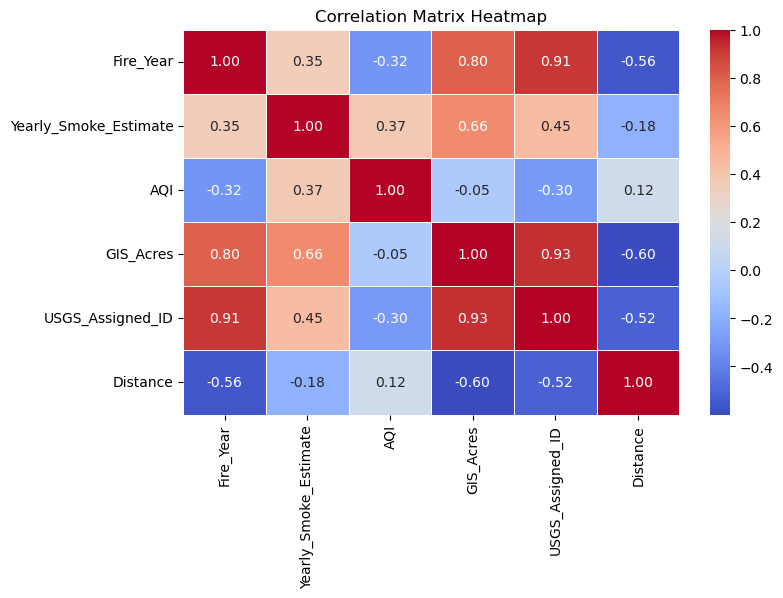

In [55]:
# Create a heatmap
plt.figure(figsize=(8, 5))  # Set the size of the heatmap
sns.heatmap(yearly_smoke_estimate.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

##### As we can see above, the correlation is 0.37 which seems reasonable considering many factors that affect smoke impact such as wind direction over a course of several days, the intensity of the fire, and its duration are not available to us. 

## Step 4: Visualizations

##### The following section includes visualizations that illustrate the results of the analysis.

#### Step 4.1: Number of fires vs Distance in Gillette, Wyoming

##### This code below generates a histogram showing the number of fires occurring every 50 mile distance from Gillette up to t1250 miles.The x-axis represents the distance in miles, while the y-axis shows the number of fires in each distance range. It uses a custom color scheme for the bars and specifies the bin width for the histogram to be 50. 


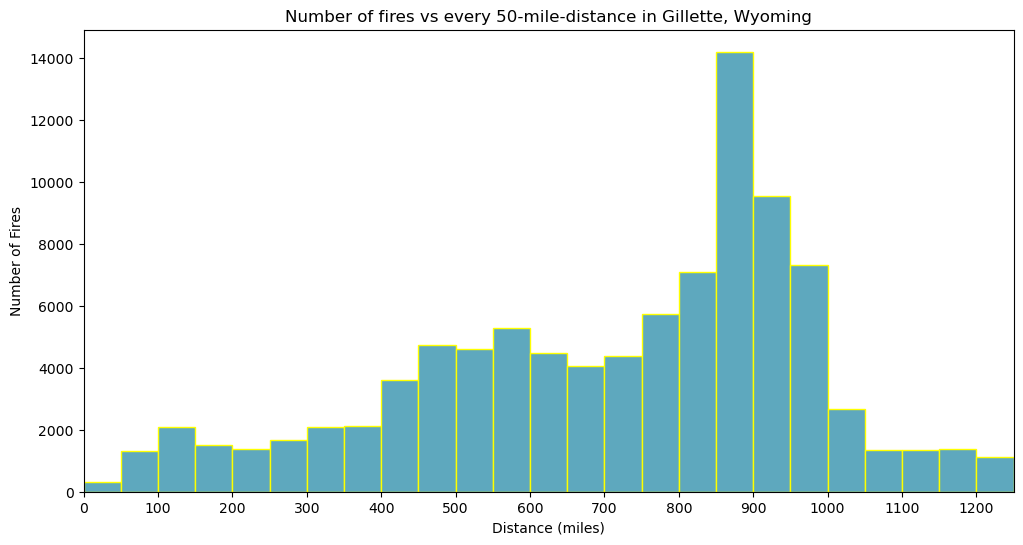

In [56]:
# Create a histogram

# Define custom colors for the bars
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df_analysis, x='Distance', bins=range(0, 1250 + 51, 50), kde=False, color = '#288BA8', edgecolor = 'yellow')
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of fires vs every 50-mile-distance in Gillette, Wyoming')

# Set x-axis labels for every 200 miles
ax.set_xticks(range(0, 1250 + 1, 100))
# Ensure that 0 on the x-axis aligns with 0 on the y-axis without a gap
plt.xlim(0, 1250)

plt.show()

#### Step 4.2: Total Acres Burned per Year within 1250 miles of Gillette Wyoming

##### The code groups the data by 'Fire_Year' and calculates the total acres burned per year within 1250 miles of Gillette, Wyoming. It creates a time series plot to visualize the annual variation in acres burned. The x-axis represents the years from 1963-2023, while the y-axis shows the total acres burned. Each data point is marked with a circular marker. The plot provides insights into the historical trends and variations in the extent of wildfires in the region over time, helping to understand the impact of fires on the landscape


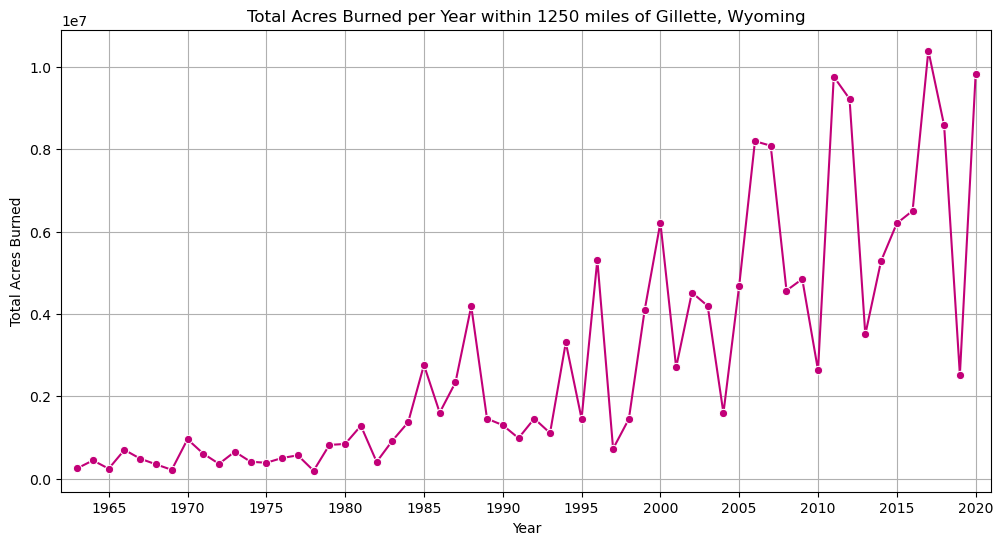

In [57]:
# Group the data by 'Fire_Year' and calculate the total acres burned per year
acres_burned_per_year = df_analysis.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

# Create a time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=acres_burned_per_year, x='Fire_Year', y='GIS_Acres', marker='o', color=sns.xkcd_rgb['magenta'])
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title(f'Total Acres Burned per Year within 1250 miles of Gillette, Wyoming')
plt.grid(True)

# Set the X-axis labels to show every 5 years
x_ticks = np.arange(1960, 2020 + 1, 5)
plt.xticks(x_ticks)
plt.xlim(1963-1, 2020+1)
plt.show()

#### Step 4.3: Fire Smoke Estimate and AQI Over Time

##### The code below creates a time series graph to visualize the trends of two variables, 'Fire Smoke Estimate' and 'AQI,' over time. It plots these two variables on the same graph, with 'Fire Year' on the x-axis and the values on the y-axis. Two line plots are generated, one for 'Fire Smoke Estimate' and another for 'AQI,' with circular markers indicating data points. The graph is labeled, and the y-axis is limited to a range of 0 to 120. It provides a visual representation of how 'Fire Smoke Estimate' and 'AQI' have evolved over the years and allows for comparisons between the two data series. The x-axis labels are set to show every 5 years for better readability.

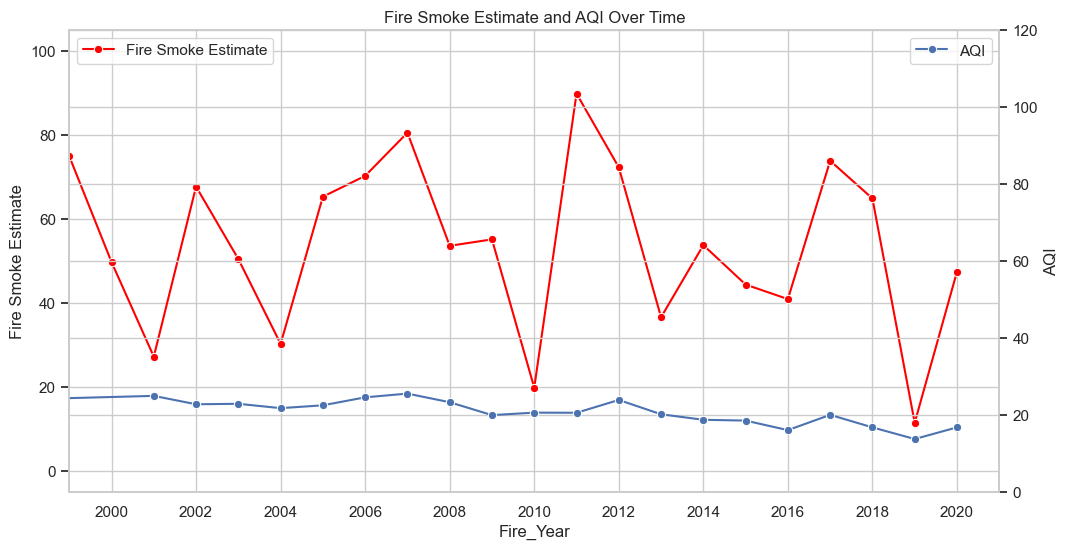

In [98]:
# Create a time series graph
plt.figure(figsize=(12, 6))  # Set the figure size
sns.set(style="whitegrid")
# Plot Fire Smoke Estimate
ax = sns.lineplot(x='Fire_Year', y='Yearly_Smoke_Estimate', data=yearly_smoke_estimate, label='Fire Smoke Estimate', marker = 'o', color = 'red')

# Create a second y-axis
ax2 = ax.twinx()

# Plot AQI Estimate
sns.lineplot(x='Fire_Year', y='AQI', data=yearly_smoke_estimate, ax = ax2, label='AQI', marker = 'o')

plt.xlabel('Year')
#plt.ylabel('Value')
plt.title('Fire Smoke Estimate and AQI Over Time')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_ylabel('Fire Smoke Estimate')
ax2.set_ylabel('AQI')
plt.ylim(0,120)
x_ticks = np.arange(2000, 2020 + 1, 2)
plt.xticks(x_ticks)
plt.xlim(2000-1, 2020+1)
plt.grid(True)
plt.show()

## Step 5: Building the Prediction Model

##### The following section develops a predictive model based on the fire data and smoke estimate. The model predicts smoke estimates for every year for the next 28 years (i.e., 2021-2049). 

##### The code utilize the ARIMA (AutoRegressive Integrated Moving Average) model for forecasting. This is a suitable choice as we do not have any predictor data available for the years 2021 - 2049 so methods such as linear regression etc are difficult to apply. ARIMA models are specifically designed for analyzing and forecasting time series data, making them well-suited for this type of problem. It's essential to note that the choice of ARIMA parameters (p, d, q) should be based on rigorous analysis and, in practice, require some experimentation and testing to find the most suitable model order for the dataset at hand. Here, I selected the values by trying a subset and seeing which one worked best to model past trends. 

##### The code below defines the order of the model, represented as (p, d, q), and then fits the ARIMA model using historical data of yearly smoke estimates. The model is employed to make predictions for a specified forecast period. The forecasted values are stored in a DataFrame with corresponding year values, extending beyond the last year in the historical data to cover the forecasted period. This allows for the creation of a complete dataset containing both historical and forecasted values. To convey appropriate levels of uncertainty in your ARIMA predictions, we calculate and plot prediction intervals. Prediction intervals provide a range within which we expect the actual values to fall with a certain level of confidence. 

In [96]:
# Determine the order (p, d, q) for the ARIMA model using analysis

# Fit the ARIMA model
arima_order = (45,0,20)  
model = ARIMA(yearly_smoke_estimate['Yearly_Smoke_Estimate'], order=arima_order)
results = model.fit()

# Make predictions (e.g., forecasting the next 12 time points)
forecast_period = 28  # Change this as needed
forecast_results = results.get_forecast(steps=forecast_period)

# Extract the forecasted values and prediction intervals
forecasted_values = forecast_results.predicted_mean
forecasted_intervals = forecast_results.conf_int()

# Create a DataFrame for the forecasted values with dates
forecast_df = pd.DataFrame(forecasted_values)
forecast_df['Year'] = range(
    yearly_smoke_estimate['Fire_Year'].max() + 1,
    yearly_smoke_estimate['Fire_Year'].max() + 1 + len(forecast_df)
)

c:\Users\mehja\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mehja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


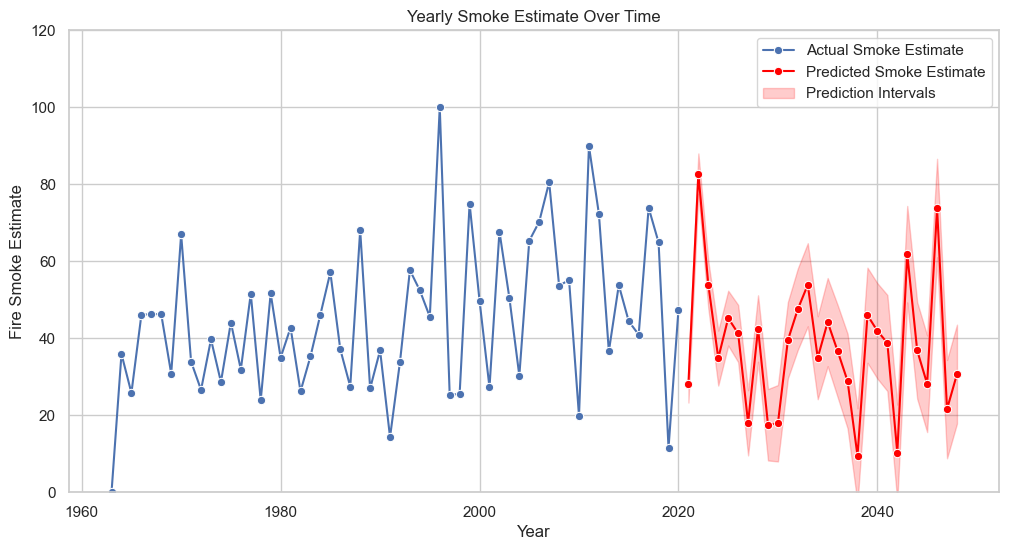

In [99]:
# Create the line plot for actual data up to 2020
plt.figure(figsize=(12, 6))
sns.lineplot(x='Fire_Year', y='Yearly_Smoke_Estimate', data=yearly_smoke_estimate, label='Actual Smoke Estimate', marker='o')

# Create the line plot for predicted data beyond 2020 with a different color
sns.lineplot(x='Year', y='predicted_mean', data=forecast_df, label='Predicted Smoke Estimate', marker='o', color='red')
plt.fill_between(
    forecast_df['Year'],
    forecasted_intervals.iloc[:, 0],
    forecasted_intervals.iloc[:, 1],
    color='red',
    alpha=0.2,
    label='Prediction Intervals',
)
plt.xlabel('Year')
plt.ylabel('Fire Smoke Estimate')
plt.title('Yearly Smoke Estimate Over Time')
plt.legend()
plt.grid(True)
plt.ylim(0,120)
plt.show()


## Step 6: Exploring Wildfire Data to Generate Additional Insights

#### Step 6.1: Total Fires per Year within 1250 Miles from Gillette, Wyoming

##### The code below analyzes and visualizes the total number of fires per year within 1250 miles of Gillette, Wyoming. The DataFrame df_analysis is grouped by the 'Fire_Year' column, and the count of unique 'USGS_Assigned_ID' values within each year is calculated, resulting in a DataFrame named fires_per_year. The code then creates a time series plot using Seaborn, depicting the trend in the total number of fires over the years. The x-axis represents the years, while the y-axis shows the count of fires. The plot includes grid lines, and the x-axis labels are set to display every 5 years, providing a clearer representation of the temporal pattern. The resulting visualization provides insights into the historical trend of fires within the specified region around Gillette, Wyoming.


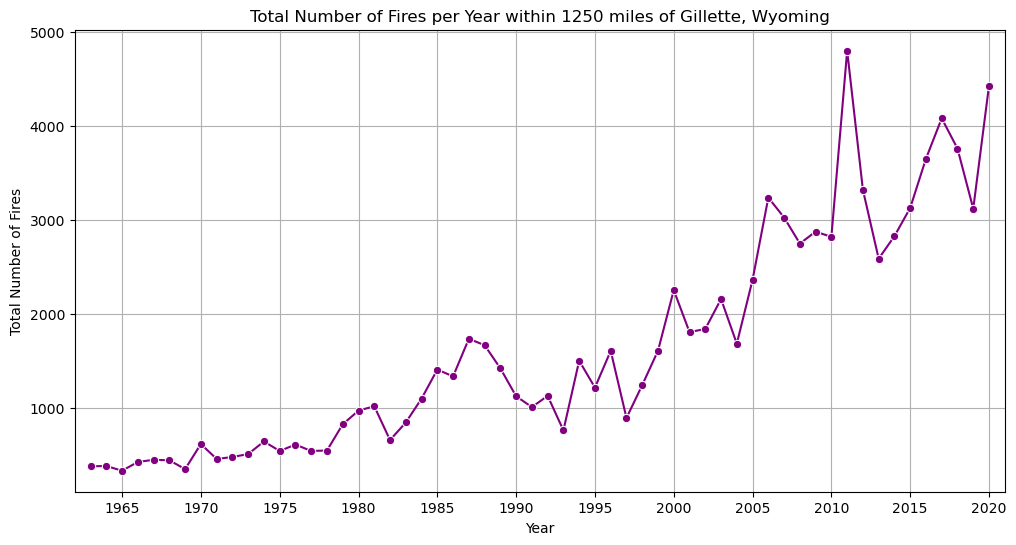

In [41]:
# Group the data by 'Fire_Year' and calculate the total number of fires burned per year
fires_per_year = df_analysis.groupby('Fire_Year')['USGS_Assigned_ID'].count().reset_index()

# Create a time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=fires_per_year, x='Fire_Year', y='USGS_Assigned_ID', marker='o', color='#800080')
plt.xlabel('Year')
plt.ylabel('Total Number of Fires')
plt.title(f'Total Number of Fires per Year within 1250 miles of Gillette, Wyoming')
plt.grid(True)

# Set the X-axis labels to show every 5 years
x_ticks = np.arange(1960, 2020 + 1, 5)
plt.xticks(x_ticks)
plt.xlim(1963-1, 2020+1)
plt.show()

#### Step 6.2: Average Distance of Fires Burned per Year from Gillette Wyoming

##### The code groups the data by 'Fire_Year' and calculates the average distance of fires per year within 1250 miles of Gillette, Wyoming. It creates a time series plot to visualize the annual variation in distance. The x-axis represents the years from 1963-2023, while the y-axis shows the average distance of fires from Gillette. Each data point is marked with a circular marker. The plot provides insights into the historical trends and variations in the distance of wildfires in the region over time, helping to understand patterns in the proximity of wildfires.


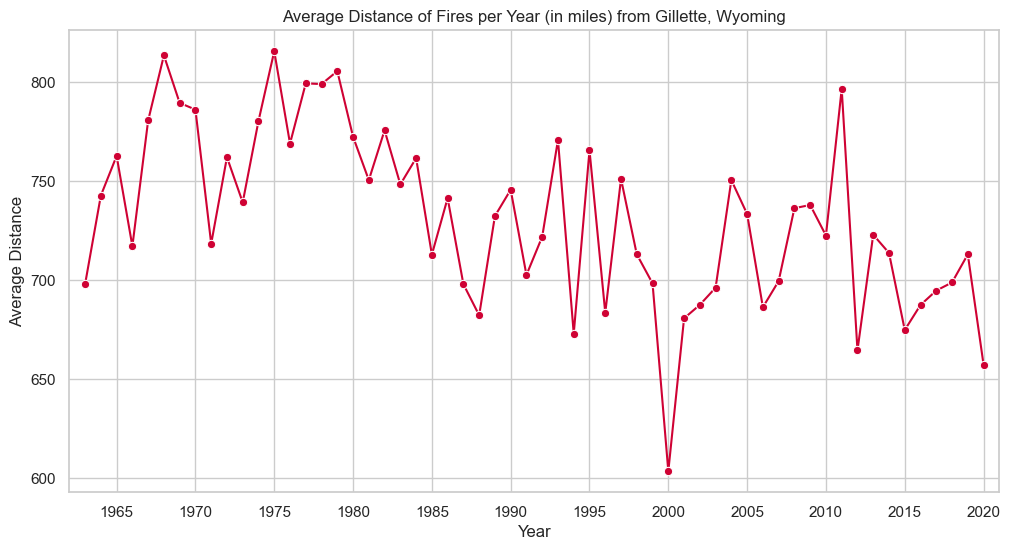

In [100]:
# Group the data by 'Fire_Year' and calculate the total number of fires burned per year
distance_per_year = df_analysis.groupby('Fire_Year')['Distance'].mean().reset_index()

# Create a time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=distance_per_year, x='Fire_Year', y='Distance', marker='o', color=sns.xkcd_rgb['cherry'])
plt.xlabel('Year')
plt.ylabel('Average Distance')
plt.title(f'Average Distance of Fires per Year (in miles) from Gillette, Wyoming')
plt.grid(True)

# Set the X-axis labels to show every 5 years
x_ticks = np.arange(1960, 2020 + 1, 5)
plt.xticks(x_ticks)
plt.xlim(1963-1, 2020+1)
plt.show()

##### As we can see above, the number of fires each year are growing and the average distance of fires from the city of Gillette seems to be decreasing. This is a cause for concern. In the section below, we will study the relationship of air quality to student learning outcomes. 


## Step 8: Investigating the Relationship of Air Quality and Student Learning Outcomes

#### Step 8.1: Read and Process National Assessment of Educational Progress (NAEP) data

##### The code below reads an Excel file named 'NAEP Data.xlsx' located at the specified path into a pandas DataFrame named `naep`. Subsequently, the code extracts specific subsets of the data related to 4th-grade Mathematics, 4th-grade Reading, 8th-grade Mathematics, and 8th-grade Reading assessments from the National Assessment of Educational Progress (NAEP). For each subset, irrelevant columns such as 'Jurisdiction,' 'All students,' 'Grade,' and 'Subject' are removed, resulting in separate DataFrames (`naep_4_math`, `naep_4_reading`, `naep_8_math`, `naep_8_reading`) tailored to the desired grade levels and subjects for further analysis. These processed DataFrames will be used for exploring and visualizing educational assessment data specifically focused on mathematics and reading performance at different grade levels.

In [102]:
# Assuming your Excel file is named 'your_file.xlsx'
naep_file_path = r"C:\Users\mehja\Documents\UW Masters\DATA 512 Human Centered Data Science\Project\NAEP Data.xlsx"

# Read the Excel file into a pandas DataFrame
naep = pd.read_excel(naep_file_path)


In [103]:
naep_4_math = naep[(naep['Grade'] == 4) & (naep['Subject'] == 'Mathematics')]
naep_4_math = naep_4_math.drop(columns=['Jurisdiction', 'All students', 'Grade', 'Subject'])
naep_4_reading = naep[(naep['Grade'] == 4) & (naep['Subject'] == 'Reading')]
naep_4_reading = naep_4_reading.drop(columns=['Jurisdiction', 'All students', 'Grade', 'Subject'])
naep_8_math = naep[(naep['Grade'] == 8) & (naep['Subject'] == 'Mathematics')]
naep_8_math = naep_8_math.drop(columns=['Jurisdiction', 'All students', 'Grade', 'Subject'])
naep_8_reading = naep[(naep['Grade'] == 8) & (naep['Subject'] == 'Reading')]
naep_8_reading = naep_8_reading.drop(columns=['Jurisdiction', 'All students', 'Grade', 'Subject'])



#### Step 8.2: Merge the NAEP dataset with WildFires dataset

##### The code below performs a series of DataFrame merges and column manipulations to integrate information from two different datasets: one containing yearly smoke estimates (yearly_smoke_estimate) and another containing National Assessment of Educational Progress (NAEP) scores for 4th-grade and 8th-grade Mathematics and Reading assessments. The code begins by merging the smoke estimate data with the 4th-grade Mathematics NAEP scores based on the 'Year' column, then renaming and dropping columns for clarity. This process is repeated for 4th-grade Reading, 8th-grade Mathematics, and 8th-grade Reading datasets, resulting in two separate DataFrames (result_df_math and result_df_reading) that combine information on smoke estimates and educational assessment scores across different grade levels and subjects. These integrated datasets are later used for exploring potential correlations or trends between smoke exposure and academic performance.

In [115]:
# Join the DataFrames on the 'Year' column
result_df_math = pd.merge(yearly_smoke_estimate, naep_4_math, right_on='Year', left_on='Fire_Year')
# Rename a specific column, for example, 'Average scale score'
result_df_math = result_df_math.rename(columns={'Average scale score': 'Grade 4 Math'})
result_df_math = result_df_math.drop(columns=['Year'])

result_df_reading = pd.merge(yearly_smoke_estimate, naep_4_reading, right_on='Year', left_on='Fire_Year')
# Rename a specific column, for example, 'Average scale score'
result_df_reading = result_df_reading.rename(columns={'Average scale score': 'Grade 4 Reading'})
result_df_reading = result_df_reading.drop(columns=['Year'])

result_df_math = pd.merge(result_df_math, naep_8_math, right_on='Year', left_on='Fire_Year')
# Rename a specific column, for example, 'Average scale score'
result_df_math = result_df_math.rename(columns={'Average scale score': 'Grade 8 Math'})
result_df_math = result_df_math.drop(columns=['Year'])

result_df_reading = pd.merge(result_df_reading, naep_8_reading, right_on='Year', left_on='Fire_Year')
# Rename a specific column, for example, 'Average scale score'
result_df_reading = result_df_reading.rename(columns={'Average scale score': 'Grade 8 Reading'})
result_df_reading = result_df_reading.drop(columns=['Year'])

#### Step 8.3: Correlation between AQI, Fire Smoke Estimate and Student Learning Outcomes

##### The provided code generates correlation matrix heatmaps for two datasets, `result_df_math` and `result_df_reading`. Each dataset combines yearly smoke estimates with National Assessment of Educational Progress (NAEP) scores for 4th-grade and 8th-grade Mathematics and Reading assessments. The code uses Seaborn's `heatmap` function to visualize the correlation matrices of the datasets, annotating each cell with the correlation coefficient and applying a cool-warm color map for clarity. These visualizations aim to reveal patterns of correlation or association between smoke exposure estimates and academic performance across different grade levels and subjects, providing insights into potential relationships between environmental factors and educational outcomes.

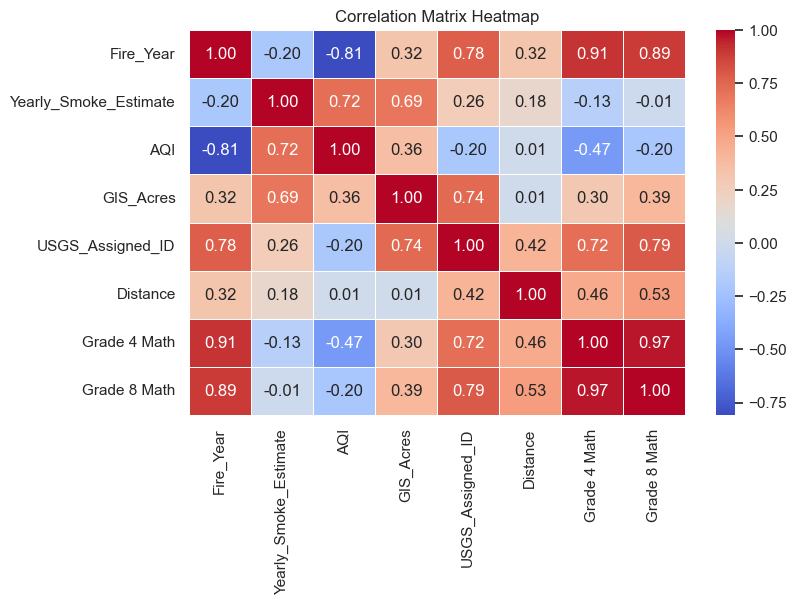

In [144]:
# Correlation between Math Test Scores, AQI and Fire Smoke Estimates
plt.figure(figsize=(8, 5))  # Set the size of the heatmap
sns.heatmap(result_df_math.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

##### As we can see above, as expected, the correlation between Math Test Scores and Yearly Smoke Estimate and AQI is negative. Negative correlation implies that as one variable increases, the other tends to decrease. In the context of Math Test Scores, Yearly Smoke Estimate, and AQI, a negative correlation suggests that higher levels of yearly smoke estimate or air quality index are associated with lower average math test scores. This negative association might be attributed to the potential impact of environmental factors, such as poor air quality or exposure to smoke, on cognitive abilities and overall academic performance. Further analysis and contextual understanding are necessary to explore the causal relationships and potential contributing factors to this observed negative correlation.

##### The code below does a similar analysis for Reading Test Scores.

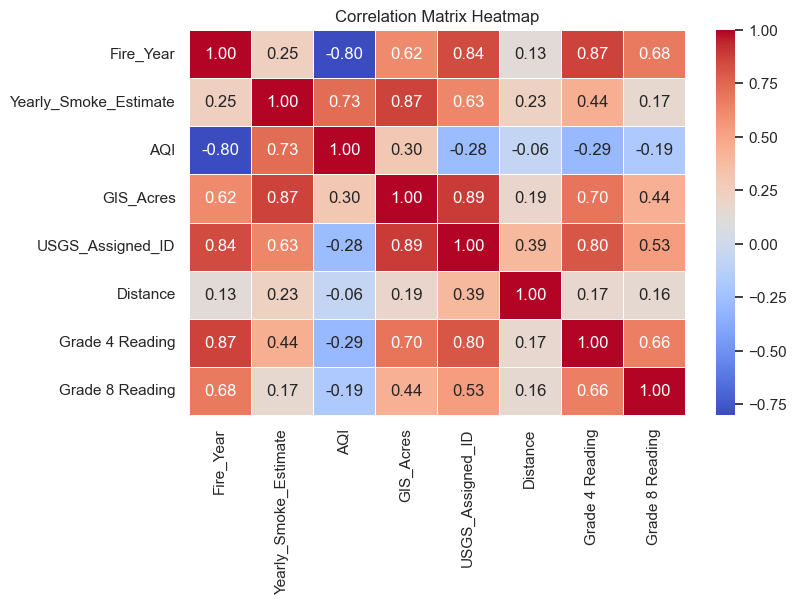

In [147]:
# Correlation between Reading Test Scores, AQI and Fire Smoke Estimates
plt.figure(figsize=(8, 5))  # Set the size of the heatmap
sns.heatmap(result_df_reading.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

##### As we can see above, as expected, the correlation between Math Test Scores and AQI is negative. However, surprisingly, the correlation between Fire Smoke Estimate and Reading Scores is positive. Negative correlation implies that as one variable increases, the other tends to decrease. In the context of Math Test Scores and AQI, a negative correlation suggests that higher levels of air quality index are associated with lower average math test scores. Further analysis and contextual understanding are necessary to explore the causal relationships and potential contributing factors to this observed negative correlation.

##### As Yearly Fire Smoke Estimates was a measure generated by us in the analysis and it does not have a robust theoretical underpinning, we will exclude it from the final visualizations below and only consider factual information such as test scores and AQI data. 

#### Step 8.4: Visualize Results between AQI and Test Scores

##### The code below generates times series graphs that visualizes the trends of various variables over time, specifically focusing on the years from 1990 to 2020. The graphs integrate data from the result_math and result_reading DataFrames, which combines yearly smoke estimates (Yearly_Smoke_Estimate), average grade scores in 4th-grade and 8th-grade Mathematics and Reading, and the Air Quality Index (AQI). Seaborn's lineplot function is used to plot each variable against the 'Fire_Year,' and distinct lines are drawn for Fire Smoke Estimate, Average Grade 4 Math Score, Average Grade 8 Math Score, Average Grade 4 Reading Score, Average Grade 8 Reading Score, and Average AQI. The graphs aim to visually explore potential patterns or correlations between smoke exposure estimates, academic performance, and air quality over the specified period, providing insights into the relationships between these variables.

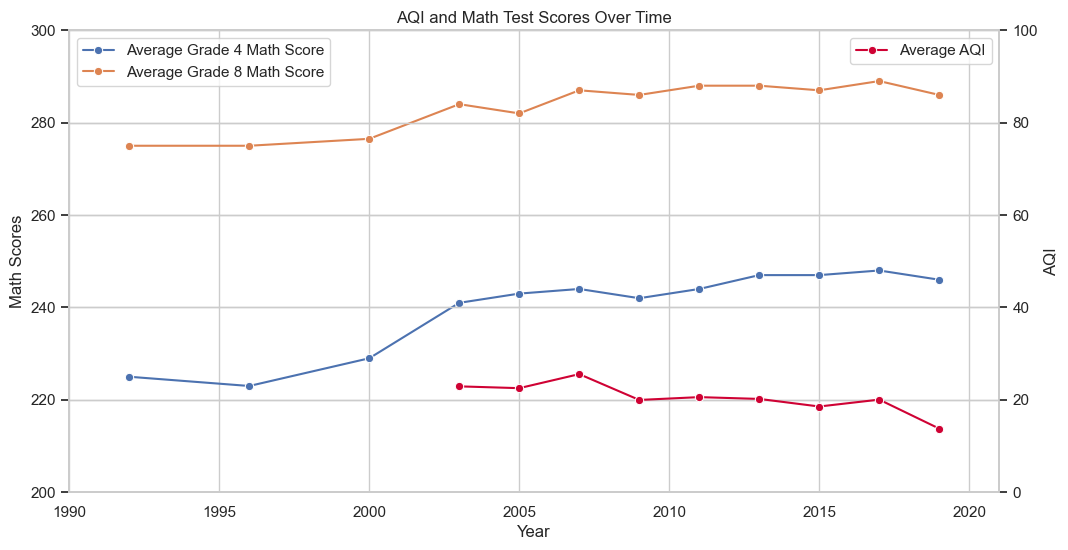

In [149]:
# Create a time series graph
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot Grade 4 Math Score
ax = sns.lineplot(x='Fire_Year', y='Grade 4 Math', data=result_df_math, label='Average Grade 4 Math Score', marker = 'o')

# Plot Grade 8 Math Score
sns.lineplot(x='Fire_Year', y='Grade 8 Math', data=result_df_math, label='Average Grade 8 Math Score', marker = 'o')

ax2 = ax.twinx()

# Plot AQI Estimate
sns.lineplot(x='Fire_Year', y='AQI', data=result_df_math, ax = ax2, label='Average AQI', marker = 'o', color=sns.xkcd_rgb['cherry'])

ax.set_xlabel('Year')
ax.set_ylabel('Math Scores')
plt.title('AQI and Math Test Scores Over Time')
ax.set_ylim(200,300)
ax2.set_ylim(0,100)
x_ticks = np.arange(1990, 2020 + 1, 5)
plt.xticks(x_ticks)
plt.xlim(1990, 2020+1)
plt.grid(True)
plt.show()

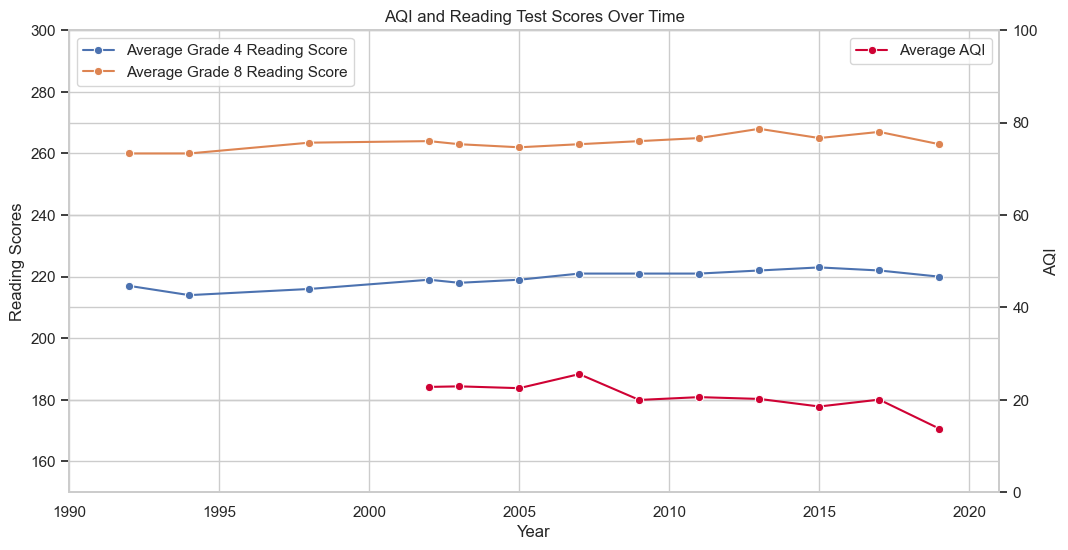

In [150]:
# Create a time series graph
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot Grade 4 Math Score
ax = sns.lineplot(x='Fire_Year', y='Grade 4 Reading', data=result_df_reading, label='Average Grade 4 Reading Score', marker = 'o')

# Plot Grade 8 Math Score
sns.lineplot(x='Fire_Year', y='Grade 8 Reading', data=result_df_reading, label='Average Grade 8 Reading Score', marker = 'o')

ax2 = ax.twinx()

# Plot AQI Estimate
sns.lineplot(x='Fire_Year', y='AQI', data=result_df_reading, ax = ax2, label='Average AQI', marker = 'o', color=sns.xkcd_rgb['cherry'])

ax.set_xlabel('Year')
ax.set_ylabel('Reading Scores')
plt.title('AQI and Reading Test Scores Over Time')
plt.legend()
ax.set_ylim(150,300)
ax2.set_ylim(0,100)
ax.legend(loc='upper left')
x_ticks = np.arange(1990, 2020 + 1, 5)
plt.xticks(x_ticks)
plt.xlim(1990, 2020+1)
plt.grid(True)
plt.show()

In [142]:
result_df_math

,Fire_Year,Yearly_Smoke_Estimate,AQI,GIS_Acres,USGS_Assigned_ID,Distance,Grade 4 Math,Grade 8 Math
0,1992,33.831070,NaN,1.456715e+06,1127,721.816303,225,275
1,1996,100.000000,NaN,5.314199e+06,1606,683.377385,223,275
2,2000,49.758613,NaN,6.217027e+06,2252,603.370364,229,276
3,2000,49.758613,NaN,6.217027e+06,2252,603.370364,229,277
4,2003,50.474149,22.92,4.193969e+06,2157,696.079247,241,284
5,2005,65.320706,22.53,4.686777e+06,2362,733.292407,243,282
6,2007,80.563971,25.57,8.086151e+06,3024,699.411291,244,287
7,2009,55.159941,19.98,4.848051e+06,2874,737.832790,242,286
8,2011,89.863275,20.59,9.764643e+06,4798,796.478765,244,288
9,2013,36.613619,20.20,3.501058e+06,2586,722.811321,247,288
